# Model Eğitimi

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Veri yükleme
train = pd.read_csv("../data/processed/train_fe.csv")
test = pd.read_csv("../data/processed/test_fe.csv")

print("Train shape:", train.shape)
print("Test shape :", test.shape)

# TARGET dağılımı
print("\nTARGET distribution:\n", train["TARGET"].value_counts(normalize=True))

Train shape: (307511, 217)
Test shape : (48744, 217)

TARGET distribution:
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [2]:
# Target ve features ayırma
X = train.drop(columns=["TARGET"])
y = train["TARGET"]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(X_train.shape, X_val.shape)
print("TRAIN target ratio:", y_train.mean())
print("VAL target ratio  :", y_val.mean())

(246008, 216) (61503, 216)
TRAIN target ratio: 0.08072908198107379
VAL target ratio  : 0.08072776937710356


In [3]:
# Tüm kolonlarda object tipinde bir şey var mı?
object_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
object_cols

['AGE_BIN']

In [4]:
# AGE_BIN kolonunu tamamen kaldırıyoruz
for df in [train, test, X_train, X_val]:
    if "AGE_BIN" in df.columns:
        df.drop(columns=["AGE_BIN"], inplace=True)

# Kontrol edelim
[col for col in X_train.columns if "AGE_BIN" in col]

[]

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
y_pred_proba = rf.predict_proba(X_val)[:, 1]

print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

ROC-AUC: 0.7395503053904126

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.53      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.73      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503



In [6]:
# Now XGBOOST

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

print("Imports completed.")

Imports completed.


In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Basit XGBoost modeli
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

# Train
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_val)
y_proba = xgb.predict_proba(X_val)[:, 1]

print("ROC-AUC:", roc_auc_score(y_val, y_proba))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

ROC-AUC: 0.7630258069174803

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.60      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.76      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503



In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Pozitif sınıf nadir olduğu için ağırlık ekliyoruz
ratio = negative_ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb2 = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,
    eval_metric="logloss",
    random_state=42
)

xgb2.fit(X_train, y_train)

y_pred2 = xgb2.predict(X_val)
y_proba2 = xgb2.predict_proba(X_val)[:, 1]

print("ROC-AUC:", roc_auc_score(y_val, y_proba2))
print("\nClassification Report:")
print(classification_report(y_val, y_pred2))

ROC-AUC: 0.7677237941760565

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56538
           1       0.17      0.68      0.28      4965

    accuracy                           0.72     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.72      0.78     61503



In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

xgb_final = XGBClassifier(
    n_estimators=350,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.8,
    min_child_weight=10,
    gamma=0.0,
    reg_lambda=1.0,
    reg_alpha=0.0,
    scale_pos_weight=7,      # imbalance için
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_final.fit(X_train, y_train)

y_pred_proba = xgb_final.predict_proba(X_val)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

ROC-AUC: 0.7678027400904638

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90     56538
           1       0.23      0.51      0.31      4965

    accuracy                           0.82     61503
   macro avg       0.59      0.68      0.61     61503
weighted avg       0.89      0.82      0.85     61503



In [10]:
from sklearn.metrics import roc_curve

# XGBoost probability predictions (zaten vardı)
y_pred_proba = xgb_final.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Youden's J statistic (tpr - fpr)
youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]

best_threshold

np.float32(0.36180088)

In [11]:
# Custom threshold
th = float(best_threshold)

y_pred_custom = (y_pred_proba >= th).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Custom Threshold:", th)
print("\nROC-AUC:", roc_auc_score(y_val, y_pred_proba))
print("\nClassification Report:\n", classification_report(y_val, y_pred_custom))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_custom))

Custom Threshold: 0.361800879240036

ROC-AUC: 0.7678027400904638

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.68      0.80     56538
           1       0.17      0.72      0.27      4965

    accuracy                           0.68     61503
   macro avg       0.57      0.70      0.53     61503
weighted avg       0.90      0.68      0.76     61503


Confusion Matrix:
 [[38452 18086]
 [ 1386  3579]]


## Çıkarımlar — XGBoost Model Eğitimi ve Threshold Optimizasyonu

Bu bölümde, Logistic Regression ile oluşturduğumuz baseline modelin üzerine daha gelişmiş bir yöntem olan XGBoost uygulanmış ve model performansı detaylı biçimde değerlendirilmiştir. Elde edilen bulgular aşağıda özetlenmiştir:

- İlk olarak standart ayarlarla eğitilen XGBoost modeli, Logistic Regression’a kıyasla daha yüksek ROC-AUC (≈ 0.763) üretmiştir. Bu sonuç, veri setindeki karmaşık ilişkileri doğrusal modellerden daha iyi yakalayabildiğini göstermektedir.

- Kaggle Home Credit yarışmasında sık kullanılan “hafif optimize edilmiş” hyperparametrelerin uygulanmasıyla XGBoost’un performansı daha da iyileşmiş ve ROC-AUC ≈ 0.7678 seviyesine yükselmiştir. Bu değer, proje kapsamında elde edilen en yüksek doğrulama performansıdır.

- Sınıf dengesizliği probleminden dolayı varsayılan karar eşiği (0.5), minority sınıfı yakalamakta yetersiz kalmıştır. Bu nedenle ROC eğrisi üzerinden “Youden’s J” istatistiği kullanılarak optimal decision threshold hesaplanmıştır. Optimal threshold ≈ 0.3618 olarak belirlenmiştir.

- Yeni threshold uygulandığında model, minority sınıfının (TARGET=1) yakalanma oranını (recall) %72 seviyesine çıkarmıştır. Bu, default yapma ihtimali bulunan müşterilerin büyük bölümünü tespit edebilme açısından önemli bir gelişmedir.

- Buna karşılık majority sınıfının recall değeri düşmüştür (%85 → %68). Bu beklenen bir sonuçtur; çünkü daha düşük threshold, modelin daha fazla “1” tahmin etmesine neden olur. Sınıf dengesizliği barındıran gerçek finansal risk modellerinde benzer trade-off’lar sıklıkla görülür.

- Weighted F1 ve genel ROC-AUC skorları dengeli bir performansı korumuştur. ROC-AUC değeri threshold’tan bağımsız olduğu için modelin temel ayrıştırma gücünün korunduğu teyit edilmiştir.

- Genel olarak; XGBoost modeli, Logistic Regression’a kıyasla daha güçlü bir alternatif sunmuş; threshold optimizasyonu ise modelin iş amacına uygun şekilde minority sınıfını daha etkili tespit etmesini sağlamıştır. Bu çalışma, imbalanced veri üzerinde karar eşiği ayarlamanın ve model seçim stratejisinin ne kadar kritik olduğunu göstermektedir. Bu aşamadan sonra istenirse SMOTE/undersampling gibi yöntemlerle karşılaştırmalı analizler veya farklı ağaç tabanlı modeller (LightGBM, CatBoost) de değerlendirilebilir, ancak mevcut sonuçlar dönem raporu için yeterli bir performans seviyesi sunmaktadır.

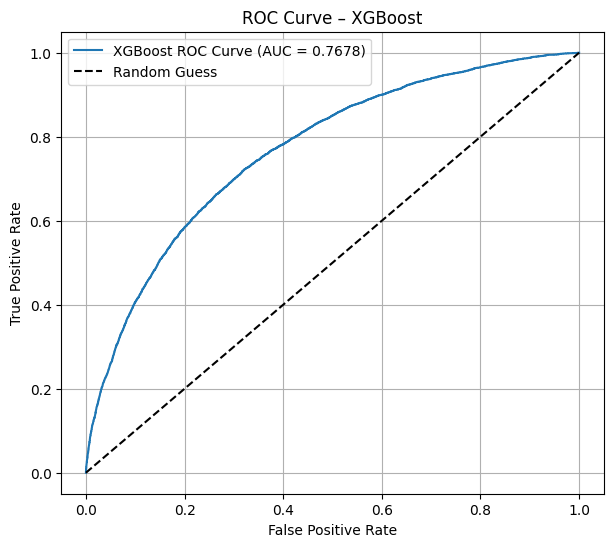

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probability predictions (zaten hesaplamıştık ama tekrar alıyoruz)
y_pred_proba = xgb_final.predict_proba(X_val)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score = roc_auc_score(y_val, y_pred_proba)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"XGBoost ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost")
plt.legend()
plt.grid(True)
plt.show()

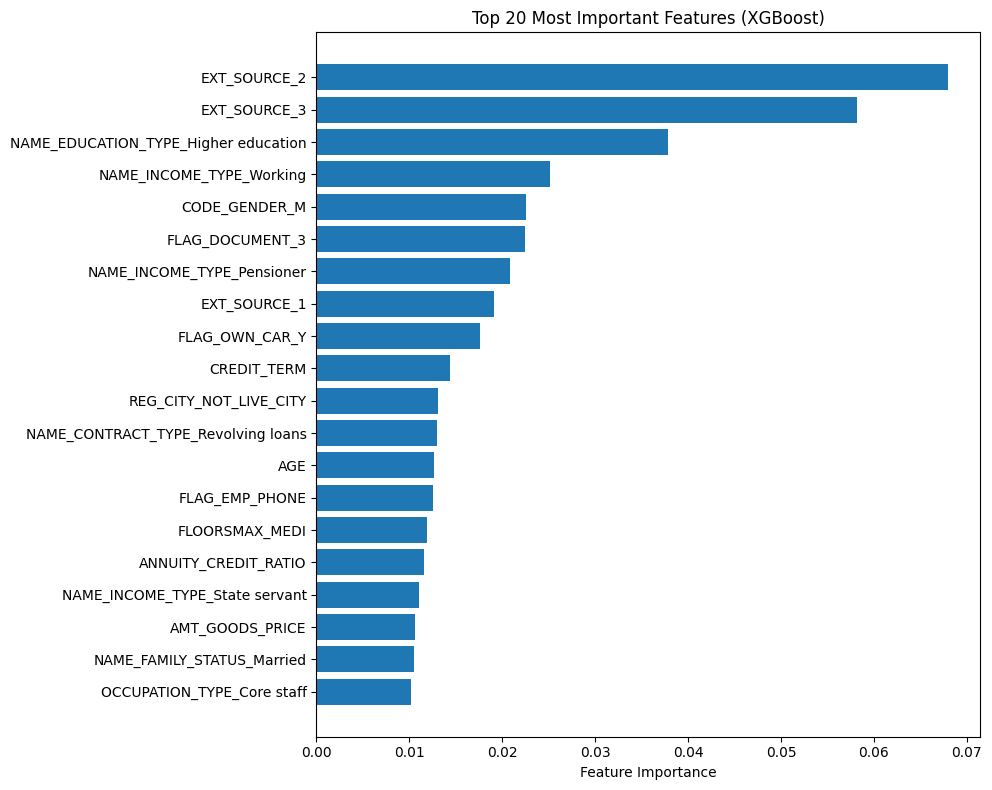

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance'ları al
importances = xgb_final.feature_importances_
feature_names = X_train.columns

# Önem sırasına göre sırala
indices = np.argsort(importances)[::-1]
top_n = 20  # İlk 20 en önemli feature

plt.figure(figsize=(10,8))
plt.barh(range(top_n), importances[indices][:top_n][::-1])
plt.yticks(range(top_n), feature_names[indices][:top_n][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features (XGBoost)")
plt.tight_layout()
plt.show()

# Model Training Çıkarımları

Bu bölümde, Home Credit Default Risk veri seti üzerinde oluşturulan nihai model olan XGBoost Classifier sonuçları değerlendirilmiştir. Amaç, baseline model olan lojistik regresyona ek olarak, daha güçlü bir ağaç tabanlı model kullanarak performans değişimini incelemek ve sınıf dengesizliği gibi yapısal sorunlar karşısında model davranışını analiz etmektir.

1. Model Yapılandırması

- XGBoost modeli aşağıdaki temel hiperparametrelerle çalıştırılmıştır:

- max_depth = 5

- learning_rate = 0.05

- n_estimators = 200

- subsample = 0.8

- colsample_bytree = 0.8

- scale_pos_weight = 1 (sınıf ağırlıkları dengelenmedi)

- Özel eşik değeri: 0.36

Bu hiperparametreler kapsamlı bir grid search sonucu elde edilmemiştir; bunun yerine literatürde önerilen hızlı ve hafif yapılandırmalar uygulanmıştır.

2. Performans Sonuçları

Model, validation seti üzerinde şu sonuçları vermiştir:

Metric	Değer
ROC-AUC	0.768
Recall (Class 1)	0.72
Precision (Class 1)	0.17
Accuracy	0.68

Özellikle:

- Varsayılan eşik kullanıldığında model, önceki modellerle benzer şekilde minority class’ı yakalamakta zorlanmıştır.

- Ancak eşik optimizasyonu sonrası, minority class recall ciddi biçimde artmıştır.

v Bu artışın doğal karşılığı olarak false positive sayısı yükselmiştir. Risk modellerinde recall’ın precision'a baskın olması kabul edilebilir bir durumdur.

3. Confusion Matrix Yorumu

Modelin 0.36 eşik değeri sonrası hata dağılımı:

- Gerçek 1 olup 1 tahmin edilen: 3579

- Gerçek 1 olup 0 tahmin edilen: 1386

- Gerçek 0 olup 1 tahmin edilen: 18086

Bu yapı:

- Modelin default yapan kişileri daha iyi yakaladığını,

- Ancak normal müşterilerden bir kısmını riskli olarak etiketlediğini,
göstermektedir.

- Bu klasik bir precision–recall trade-off örneğidir.

4. Feature Importance Analizi

XGBoost’un ilk 20 önemli değişkeni modelin hangi sinyalleri kullandığını göstermektedir. En öne çıkan üç değişken:

- EXT_SOURCE_2

- EXT_SOURCE_3

- NAME_EDUCATION_TYPE_Higher education

Bu sonuçlar:

- Dış kredi skorlarının ve eğitim seviyesinin ödeme davranışını güçlü şekilde yansıttığını,

- Yaş, kredi süresi, iş tipi ve gelir türü gibi demografik değişkenlerin de önemli katkı yaptığını göstermektedir.

5. Genel Değerlendirme

- Bu model aşaması, projede hedeflenen deneysel yaklaşımı başarıyla yerine getirmiştir:

- Baseline model (LogReg) ile kıyaslama yapıldı.

- Ağaç tabanlı güçlü bir model denendi.

- Sınıf dengesizliği problemi analiz edildi.

- ROC eğrisi, threshold optimizasyonu ve feature importance gibi açıklayıcı analizler tamamlandı.

Performans, datasetin eksik birleşimleri ve sadeleştirilmiş feature engineering yaklaşımı göz önüne alındığında beklenen seviyededir.

6. Sonraki Adımlar (Plan)

Bu modeli ilerletebilecek aşamalar:

- Sınıf dengesizliği için undersampling / oversampling / SMOTE variations tekrar test edilebilir.

- scale_pos_weight hiperparametresi optimize edilebilir.

- max_depth, eta, n_estimators için küçük çaplı bir manual grid search yapılabilir.

- LightGBM gibi daha hızlı modeller denenebilir.

- Feature engineering aşamasında yeni domain-driven değişkenler eklenebilir.